# How to Make a Successful Movie 

* Student name: James M. Irving
* Student pace: full time
* Scheduled project review date/time: TBD
* Instructor name: Life
* Blog post URL: TBD

<img src="images/theatre-background-color-crop.jpg">

In [56]:
# import os
# print("PYTHONPATH:", os.environ.get('PYTHONPATH'))
# print("PATH:", os.environ.get('PATH'))

# Overview

This project analyzes attributes of successfull movies from the last decade in order to identify traits of successfull films.

# Business Problem

> Microsoft has decided to create a new movie studio, but they don’t know anything about creating movies. 
The goal of this analysis is to explore what types of films are currently doing the best at the box office, and to provide actionable recommendations to Microsoft on what type of files to create or to avoid.


## Questions to Answer

- Q1: What genre has the highest median revenue?
    - Is this different if I use ROI instead of revenue?
- Q2: Does release month have an effect on revenue?
- Q3: Is there a relationship between budget and ratings?

# Data Understanding & Prep

## Imports & Functions

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, glob
import numpy as np
## Set pandas options
pd.set_option('display.max_columns',0)
pd.set_option('display.float_format',lambda x: f"{x:,.2f}")

## Set figure aesthetics
# sns.set_style('dark')
plt.rcParams['figure.figsize'] = (10,4)
plt.style.use('seaborn-talk')
plt.style.use('dark_background')


In [5]:
def check_nulls(df):
    """Returns a dataframe of null value counts and % null"""
    nulls = pd.DataFrame({'# Null':df.isna().sum(),
                 '% Null': (df.isna().sum()/len(df)*100).round(2)})
    return nulls

In [6]:
from matplotlib.ticker import FuncFormatter

def millions(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    return f"$ {x*1e-6:,}M"

def billions(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in billions"""
    return f"$ {x*1e-9:,}B"


def get_funcformatter(kind='m'):
    """Returns a matplotlib FuncFormatter for formatting currecny in millions or billions
    
    Args:
        kind (str): which order of magnitude to use. Default is 'm'. 
                    m=Millions, b=Billions
    """
    if kind.lower()=='m':
        func = millions
    elif kind.lower()=='b':
        func = billions
    return FuncFormatter(func)


In [7]:
## Creating color palettes
palette_muted = sns.color_palette('muted')
palette_dark = sns.color_palette('dark')

## Selecting Our Data

- Microsoft provided 11 csv files with movie info that they suggested we use. Below we loaded all provided tables and previewed them to determine the ideal data sources to use.

In [8]:
## Files provided by microsoft
files = glob.glob('zippedData/*.csv*')

In [9]:
## Load all files into a dict using their filename as key
tables = {}
dashes='---'*25

for file in files:
    ## Save a variable-friendly version of the file name
    table_name = file.replace('.csv.gz','').split('/')[-1].replace('.','_')
    print(dashes)
    
    ## Load and preview dataframe
    print(f"Preview of {table_name}")
    tables[table_name] = pd.read_csv(file)
    display(tables[table_name].head(5))
    print()
    

---------------------------------------------------------------------------
Preview of imdb_title_crew


,tconst,directors,writers
0,tt0285252,nm0899854,nm0899854
1,tt0438973,NaN,"nm0175726,nm1802864"
2,tt0462036,nm1940585,nm1940585
3,tt0835418,nm0151540,"nm0310087,nm0841532"
4,tt0878654,"nm0089502,nm2291498,nm2292011",nm0284943



---------------------------------------------------------------------------
Preview of tmdb_movies


,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.53,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.70,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.73,2010-03-26,How to Train Your Dragon,7.70,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.52,2010-05-07,Iron Man 2,6.80,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.00,1995-11-22,Toy Story,7.90,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.92,2010-07-16,Inception,8.30,22186



---------------------------------------------------------------------------
Preview of imdb_title_akas


,title_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,NaN,NaN,0.00
1,tt0369610,11,Jurashikku warudo,JP,NaN,imdbDisplay,NaN,0.00
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,NaN,imdbDisplay,NaN,0.00
3,tt0369610,13,O Mundo dos Dinossauros,BR,NaN,NaN,short title,0.00
4,tt0369610,14,Jurassic World,FR,NaN,imdbDisplay,NaN,0.00



---------------------------------------------------------------------------
Preview of imdb_title_ratings


,tconst,averagerating,numvotes
0,tt10356526,8.30,31
1,tt10384606,8.90,559
2,tt1042974,6.40,20
3,tt1043726,4.20,50352
4,tt1060240,6.50,21



---------------------------------------------------------------------------
Preview of imdb_name_basics


,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
0,nm0061671,Mary Ellen Bauder,nan,nan,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553"
1,nm0061865,Joseph Bauer,nan,nan,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940"
2,nm0062070,Bruce Baum,nan,nan,"miscellaneous,actor,writer","tt1470654,tt0363631,tt0104030,tt0102898"
3,nm0062195,Axel Baumann,nan,nan,"camera_department,cinematographer,art_department","tt0114371,tt2004304,tt1618448,tt1224387"
4,nm0062798,Pete Baxter,nan,nan,"production_designer,art_department,set_decorator","tt0452644,tt0452692,tt3458030,tt2178256"



---------------------------------------------------------------------------
Preview of imdb_title_basics


,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.00,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.00,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.00,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,nan,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.00,"Comedy,Drama,Fantasy"



---------------------------------------------------------------------------
Preview of tn_movie_budgets


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"



---------------------------------------------------------------------------
Preview of bom_movie_gross


,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,"415,000,000.00",652000000,2010
1,Alice in Wonderland (2010),BV,"334,200,000.00",691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,"296,000,000.00",664300000,2010
3,Inception,WB,"292,600,000.00",535700000,2010
4,Shrek Forever After,P/DW,"238,700,000.00",513900000,2010



---------------------------------------------------------------------------
Preview of imdb_title_principals


,tconst,ordering,nconst,category,job,characters
0,tt0111414,1,nm0246005,actor,NaN,"[""The Man""]"
1,tt0111414,2,nm0398271,director,NaN,NaN
2,tt0111414,3,nm3739909,producer,producer,NaN
3,tt0323808,10,nm0059247,editor,NaN,NaN
4,tt0323808,1,nm3579312,actress,NaN,"[""Beth Boothby""]"


The tables we ultimately used were the following:
-  `tn_movie_budgets` for the financial data, including production budget. 
- `imdb_title_basics` for the basic information on runtime and genres.


## Cleaning the Selected Data

In [10]:
tables['tn_movie_budgets'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [11]:
tables['bom_movie_gross'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


### Cleaning `tn_movie_budgets`

In [12]:
## copy table 
df = tables['tn_movie_budgets'].copy()
df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


In [13]:
## Check df info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [14]:
## Check nulls
check_nulls(df)

,# Null,% Null
id,0,0.00
release_date,0,0.00
movie,0,0.00
production_budget,0,0.00
domestic_gross,0,0.00
worldwide_gross,0,0.00


#### Notes on tn_movie_budgets:
- Financial columns are strings 
- no null values to worry about.
- release_date could be converted to datetime

In [15]:
## Testing convert production_budget
df['production_budget'].map(lambda x: x.replace('$','').replace(',',''))

0       425000000
1       410600000
2       350000000
3       330600000
4       317000000
          ...    
5777         7000
5778         6000
5779         5000
5780         1400
5781         1100
Name: production_budget, Length: 5782, dtype: object

In [16]:
## What is the % null?
(df.isna().sum()/len(df)*100)

id                  0.00
release_date        0.00
movie               0.00
production_budget   0.00
domestic_gross      0.00
worldwide_gross     0.00
dtype: float64

In [17]:
## Convert Money Columns to Floats
for col in ['production_budget','domestic_gross','worldwide_gross']:
    df[col] = df[col].map(lambda x: x.replace('$','').replace(',','')).astype(float)
df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"425,000,000.00","760,507,625.00","2,776,345,279.00"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"410,600,000.00","241,063,875.00","1,045,663,875.00"
2,3,"Jun 7, 2019",Dark Phoenix,"350,000,000.00","42,762,350.00","149,762,350.00"
3,4,"May 1, 2015",Avengers: Age of Ultron,"330,600,000.00","459,005,868.00","1,403,013,963.00"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"317,000,000.00","620,181,382.00","1,316,721,747.00"
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"7,000.00",0.00,0.00
5778,79,"Apr 2, 1999",Following,"6,000.00","48,482.00","240,495.00"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"5,000.00","1,338.00","1,338.00"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"1,400.00",0.00,0.00


In [18]:
# from ipywidgets import interact

# @interact
# def plot_style(style=plt.style.available):

#     with plt.style.context(style):
#         plt.figure()
#         ax = sns.regplot(data=df,x='production_budget',y='worldwide_gross')
#         ax.set_title(style)
#         plt.show()

In [19]:
## Make a folder for the clean data
FOLDER = './cleaned_data/'
os.makedirs(FOLDER, exist_ok=True)

In [20]:
## Save clean_csv 
df.to_csv(f"{FOLDER}tn_movie_budgets_clean.csv",index=False)

In [21]:
## Load back in the clean tn_movie_budgets with release dates as datetime dtype
tn_movie_budgets = pd.read_csv("cleaned_data/tn_movie_budgets_clean.csv", 
                               parse_dates=['release_date'])
tn_movie_budgets['release_date'].dt.quarter

0       4
1       2
2       2
3       2
4       4
       ..
5777    4
5778    2
5779    3
5780    3
5781    3
Name: release_date, Length: 5782, dtype: int64

### Cleaning `imdb_title_basics`

In [22]:
df = tables['imdb_title_basics'].copy()
df

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.00,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.00,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.00,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,nan,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.00,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.00,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,nan,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,nan,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.00,NaN


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   tconst           146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [24]:
check_nulls(df)

,# Null,% Null
tconst,0,0.00
primary_title,0,0.00
original_title,21,0.01
start_year,0,0.00
runtime_minutes,31739,21.72
genres,5408,3.70


#### Notes on `imdb_title_basics`
- Contains genres but in as a string with multiple genres combined
    - Separate genres 
- Large Number of Nulls from runtime_minutes (~22%)
    - Potentially drop them OR
    - Fill in with median?
    
- Some nulls in genre.
    - As long as no big-name movies missing genres -> drop nulls from genres
  

In [25]:
## What movies are missing genre
null_genres = df[df['genres'].isna()].sort_values('start_year')
display(null_genres.head(10), null_genres.tail(10))

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
18738,tt1819635,Ocaso,Ocaso,2010,80.00,NaN
123475,tt7493048,Zoi podilato,Zoi podilato,2010,nan,NaN
31823,tt2200832,Beyond Belief,Beyond Belief,2010,80.00,NaN
110268,tt6448910,Febiofest 2010,Febiofest 2010,2010,nan,NaN
10616,tt1604602,Running on Empty,Ranningu on enputi,2010,80.00,NaN
110263,tt6448882,Hu Wang Gui Lai,Hu Wang Gui Lai,2010,nan,NaN
32354,tt2217494,Art of the Japanese Sword,Art of the Japanese Sword,2010,83.00,NaN
10681,tt1606611,Hitoya ni saku hana,Hitoya ni saku hana,2010,nan,NaN
110255,tt6448850,Indie-AniFest 2010,Indie-AniFest 2010,2010,nan,NaN
11065,tt1619045,The HIV Story Project,The HIV Story Project,2010,nan,NaN


,tconst,primary_title,original_title,start_year,runtime_minutes,genres
3015,tt10304138,Unitlted Disney Live Action Project,Unitlted Disney Live Action Project,2022,nan,NaN
2904,tt10298810,Untitled Pixar Animation Project,Untitled Pixar Animation Project,2022,nan,NaN
3016,tt10304140,Unitlted Disney Live Action Project,Unitlted Disney Live Action Project,2022,nan,NaN
3017,tt10304142,Unitlted Disney Live Action Project,Unitlted Disney Live Action Project,2022,nan,NaN
3018,tt10304194,Untitled Disney Live Action Project,Untitled Disney Live Action Project,2022,nan,NaN
135475,tt8582042,Lost in Time,Lost in Time,2022,nan,NaN
2905,tt10298840,Untitled Disney Animation Project,Untitled Disney Animation Project,2022,nan,NaN
111226,tt6495056,Untitled Illumination Entertainment Project,Untitled Illumination Entertainment Project,2023,nan,NaN
2906,tt10298848,Untitled Disney Live-Action Project,Untitled Disney Live-Action Project,2023,nan,NaN
2948,tt10300396,Untitled Star Wars Film,Untitled Star Wars Film,2024,nan,NaN


>- Some movies without genre are unreleased, others seem to be foreigh or indie/niche. 
    - Drop nulls from genre


In [26]:
## remove unreleased movies
df = df[df['start_year']<2021]
df

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.00,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.00,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.00,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,nan,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.00,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.00,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,nan,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,nan,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.00,NaN


In [27]:
## Drop remaining nulls from genre
df = df.dropna(subset=['genres'])
df

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.00,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.00,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.00,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,nan,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.00,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146138,tt9916428,The Secret of China,The Secret of China,2019,nan,"Adventure,History,War"
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.00,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,nan,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,nan,Comedy


In [28]:
## delete nulls df
del null_genres

In [29]:
## Check movies missing run_time, sort by start-year
null_df = df[df['runtime_minutes'].isna()].sort_values('start_year')
display(null_df.head(10),null_df.tail(10))

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
54585,tt3208228,To Sir with Love,Khru ban nok ban nong hii yai,2010,nan,Drama
64327,tt3688022,Stephen K Amos: The Feelgood Factor,Stephen K Amos: The Feelgood Factor,2010,nan,"Comedy,Documentary"
17146,tt1777046,Petrified,Petrified,2010,nan,"Drama,Horror"
64332,tt3688314,Mammoth: Titan of the Ice Age,Mammoth: Titan of the Ice Age,2010,nan,Documentary
6948,tt1354720,The Uncoded,The Uncoded,2010,nan,Drama
123783,tt7520478,Salam Bar Eshgh,Salam Bar Eshgh,2010,nan,"Crime,Drama"
64385,tt3690096,Le livre de Marc,Le livre de Marc,2010,nan,Drama
17109,tt1776272,Outliers,Outliers,2010,nan,Action
17084,tt1776147,De Nova... The Road Less Trodden,De Nova... The Road Less Trodden,2010,nan,Drama
6998,tt1364277,The Platinum Peacemaker,The Platinum Peacemaker,2010,nan,"Comedy,Western"


,tconst,primary_title,original_title,start_year,runtime_minutes,genres
3207,tt10319486,Pesti balhé,Pesti balhé,2020,nan,"Action,Comedy"
140300,tt9093890,When I'm Done Dying,When I'm Done Dying,2020,nan,Drama
114869,tt6802400,Coming 2 America,Coming 2 America,2020,nan,Comedy
4185,tt10393488,The Dead of Night,The Dead of Night,2020,nan,Thriller
123765,tt7518786,'83,'83,2020,nan,"Biography,Drama,Sport"
3206,tt10319442,Peponi,Peponi,2020,nan,Crime
102492,tt5996648,The Grundles: Your Friendly Neighborhood Monsters,The Grundles: Your Friendly Neighborhood Monsters,2020,nan,"Animation,Comedy,Family"
135910,tt8638636,Ji guang zhen,Ji guang zhen,2020,nan,"Sci-Fi,Thriller"
119125,tt7146812,Onward,Onward,2020,nan,"Adventure,Animation,Comedy"
121769,tt7350404,The Nazi Officer's Wife,The Nazi Officer's Wife,2020,nan,Drama


In [30]:
## Drop the one missing original title
df = df.dropna(subset=['original_title'])
df

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.00,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.00,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.00,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,nan,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.00,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146138,tt9916428,The Secret of China,The Secret of China,2019,nan,"Adventure,History,War"
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.00,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,nan,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,nan,Comedy


In [31]:
## final null check
check_nulls(df)

,# Null,% Null
tconst,0,0.00
primary_title,0,0.00
original_title,0,0.00
start_year,0,0.00
runtime_minutes,28395,20.19
genres,0,0.00


In [32]:
## Save and reload csv
filename = f"{FOLDER}imdb_title_basics_clean.csv"
df.to_csv(filename,index=False)
imdb_title_basics = pd.read_csv(filename)
imdb_title_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140620 entries, 0 to 140619
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   tconst           140620 non-null  object 
 1   primary_title    140620 non-null  object 
 2   original_title   140620 non-null  object 
 3   start_year       140620 non-null  int64  
 4   runtime_minutes  112225 non-null  float64
 5   genres           140620 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.4+ MB


## Merging the Data:
- `tn_movie_budgets` & `imdb_title_basics` 

In [33]:
## Preview before merging
display(tn_movie_budgets.head(3),imdb_title_basics.head(3))

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,"425,000,000.00","760,507,625.00","2,776,345,279.00"
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"410,600,000.00","241,063,875.00","1,045,663,875.00"
2,3,2019-06-07,Dark Phoenix,"350,000,000.00","42,762,350.00","149,762,350.00"


,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.00,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.00,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.00,Drama


- Merge using the movie names 
    - left table:
        - tn_movie_budgets
        - on = "movie"
    - right table;
        - imdb_title_basics
        - on = ...original_title?

In [34]:
df = pd.merge(tn_movie_budgets,imdb_title_basics,left_on='movie',
         right_on='original_title')
df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"410,600,000.00","241,063,875.00","1,045,663,875.00",tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011,136.00,"Action,Adventure,Fantasy"
1,3,2019-06-07,Dark Phoenix,"350,000,000.00","42,762,350.00","149,762,350.00",tt6565702,Dark Phoenix,Dark Phoenix,2019,113.00,"Action,Adventure,Sci-Fi"
2,4,2015-05-01,Avengers: Age of Ultron,"330,600,000.00","459,005,868.00","1,403,013,963.00",tt2395427,Avengers: Age of Ultron,Avengers: Age of Ultron,2015,141.00,"Action,Adventure,Sci-Fi"
3,7,2018-04-27,Avengers: Infinity War,"300,000,000.00","678,815,482.00","2,048,134,200.00",tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.00,"Action,Adventure,Sci-Fi"
4,9,2017-11-17,Justice League,"300,000,000.00","229,024,295.00","655,945,209.00",tt0974015,Justice League,Justice League,2017,120.00,"Action,Adventure,Fantasy"
...,...,...,...,...,...,...,...,...,...,...,...,...
3462,67,2006-04-28,Clean,"10,000.00","138,711.00","138,711.00",tt6619196,Clean,Clean,2017,70.00,"Comedy,Drama,Horror"
3463,68,2001-07-06,Cure,"10,000.00","94,596.00","94,596.00",tt1872026,Cure,Cure,2011,93.00,Drama
3464,73,2012-01-13,Newlyweds,"9,000.00","4,584.00","4,584.00",tt1880418,Newlyweds,Newlyweds,2011,95.00,"Comedy,Drama"
3465,78,2018-12-31,Red 11,"7,000.00",0.00,0.00,tt7837402,Red 11,Red 11,2019,77.00,"Horror,Sci-Fi,Thriller"


In [35]:
df.isna().sum()

id                     0
release_date           0
movie                  0
production_budget      0
domestic_gross         0
worldwide_gross        0
tconst                 0
primary_title          0
original_title         0
start_year             0
runtime_minutes      411
genres                 0
dtype: int64

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3467 entries, 0 to 3466
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 3467 non-null   int64         
 1   release_date       3467 non-null   datetime64[ns]
 2   movie              3467 non-null   object        
 3   production_budget  3467 non-null   float64       
 4   domestic_gross     3467 non-null   float64       
 5   worldwide_gross    3467 non-null   float64       
 6   tconst             3467 non-null   object        
 7   primary_title      3467 non-null   object        
 8   original_title     3467 non-null   object        
 9   start_year         3467 non-null   int64         
 10  runtime_minutes    3056 non-null   float64       
 11  genres             3467 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(5)
memory usage: 352.1+ KB


In [37]:
check_nulls(df)

,# Null,% Null
id,0,0.00
release_date,0,0.00
movie,0,0.00
production_budget,0,0.00
domestic_gross,0,0.00
worldwide_gross,0,0.00
tconst,0,0.00
primary_title,0,0.00
original_title,0,0.00
start_year,0,0.00


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3467 entries, 0 to 3466
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 3467 non-null   int64         
 1   release_date       3467 non-null   datetime64[ns]
 2   movie              3467 non-null   object        
 3   production_budget  3467 non-null   float64       
 4   domestic_gross     3467 non-null   float64       
 5   worldwide_gross    3467 non-null   float64       
 6   tconst             3467 non-null   object        
 7   primary_title      3467 non-null   object        
 8   original_title     3467 non-null   object        
 9   start_year         3467 non-null   int64         
 10  runtime_minutes    3056 non-null   float64       
 11  genres             3467 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(5)
memory usage: 352.1+ KB


### Save and Load Merged Dataset

In [39]:
file = 'cleaned_data/merged_budgets_title_basics.csv'
df.to_csv(file,index=False)
df = pd.read_csv(file, parse_dates=['release_date'])
df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"410,600,000.00","241,063,875.00","1,045,663,875.00",tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011,136.00,"Action,Adventure,Fantasy"
1,3,2019-06-07,Dark Phoenix,"350,000,000.00","42,762,350.00","149,762,350.00",tt6565702,Dark Phoenix,Dark Phoenix,2019,113.00,"Action,Adventure,Sci-Fi"
2,4,2015-05-01,Avengers: Age of Ultron,"330,600,000.00","459,005,868.00","1,403,013,963.00",tt2395427,Avengers: Age of Ultron,Avengers: Age of Ultron,2015,141.00,"Action,Adventure,Sci-Fi"
3,7,2018-04-27,Avengers: Infinity War,"300,000,000.00","678,815,482.00","2,048,134,200.00",tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.00,"Action,Adventure,Sci-Fi"
4,9,2017-11-17,Justice League,"300,000,000.00","229,024,295.00","655,945,209.00",tt0974015,Justice League,Justice League,2017,120.00,"Action,Adventure,Fantasy"
...,...,...,...,...,...,...,...,...,...,...,...,...
3462,67,2006-04-28,Clean,"10,000.00","138,711.00","138,711.00",tt6619196,Clean,Clean,2017,70.00,"Comedy,Drama,Horror"
3463,68,2001-07-06,Cure,"10,000.00","94,596.00","94,596.00",tt1872026,Cure,Cure,2011,93.00,Drama
3464,73,2012-01-13,Newlyweds,"9,000.00","4,584.00","4,584.00",tt1880418,Newlyweds,Newlyweds,2011,95.00,"Comedy,Drama"
3465,78,2018-12-31,Red 11,"7,000.00",0.00,0.00,tt7837402,Red 11,Red 11,2019,77.00,"Horror,Sci-Fi,Thriller"


## Feature Engineering

### Revenue

In [40]:
df['revenue_domestic'] = df['domestic_gross'] - df['production_budget']
df['revenue_worldwide'] = df['worldwide_gross'] - df['production_budget']

In [41]:
df['lost_money'] = df['revenue_domestic']<0
df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,tconst,primary_title,original_title,start_year,runtime_minutes,genres,revenue_domestic,revenue_worldwide,lost_money
0,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"410,600,000.00","241,063,875.00","1,045,663,875.00",tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011,136.00,"Action,Adventure,Fantasy","-169,536,125.00","635,063,875.00",True
1,3,2019-06-07,Dark Phoenix,"350,000,000.00","42,762,350.00","149,762,350.00",tt6565702,Dark Phoenix,Dark Phoenix,2019,113.00,"Action,Adventure,Sci-Fi","-307,237,650.00","-200,237,650.00",True
2,4,2015-05-01,Avengers: Age of Ultron,"330,600,000.00","459,005,868.00","1,403,013,963.00",tt2395427,Avengers: Age of Ultron,Avengers: Age of Ultron,2015,141.00,"Action,Adventure,Sci-Fi","128,405,868.00","1,072,413,963.00",False
3,7,2018-04-27,Avengers: Infinity War,"300,000,000.00","678,815,482.00","2,048,134,200.00",tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.00,"Action,Adventure,Sci-Fi","378,815,482.00","1,748,134,200.00",False
4,9,2017-11-17,Justice League,"300,000,000.00","229,024,295.00","655,945,209.00",tt0974015,Justice League,Justice League,2017,120.00,"Action,Adventure,Fantasy","-70,975,705.00","355,945,209.00",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3462,67,2006-04-28,Clean,"10,000.00","138,711.00","138,711.00",tt6619196,Clean,Clean,2017,70.00,"Comedy,Drama,Horror","128,711.00","128,711.00",False
3463,68,2001-07-06,Cure,"10,000.00","94,596.00","94,596.00",tt1872026,Cure,Cure,2011,93.00,Drama,"84,596.00","84,596.00",False
3464,73,2012-01-13,Newlyweds,"9,000.00","4,584.00","4,584.00",tt1880418,Newlyweds,Newlyweds,2011,95.00,"Comedy,Drama","-4,416.00","-4,416.00",True
3465,78,2018-12-31,Red 11,"7,000.00",0.00,0.00,tt7837402,Red 11,Red 11,2019,77.00,"Horror,Sci-Fi,Thriller","-7,000.00","-7,000.00",True


### ROI

$$\text{ROI(%)}= \frac{\text{revenue}}{\text{investment}}*100$$

In [42]:
## Calculate ROI
df['roi_domestic'] = (df['revenue_domestic'] / df['production_budget'])*100
df['roi_worldwide'] = (df['revenue_worldwide'] / df['production_budget'])*100

### Release Month

In [43]:
## making release date into datetime for month
df['release_date'] = pd.to_datetime(df['release_date'])
df['release_date'].map(lambda x: x.year)
df['release_month'] = df['release_date'].dt.month

# SAVING FINAL FILE FOR CLASS

In [44]:
df.to_csv('joined_movie_data_for_sg.csv',index=False)

# Analysis

## Q1: Which genre generates the most revenue ?

In [45]:
df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,tconst,primary_title,original_title,start_year,runtime_minutes,genres,revenue_domestic,revenue_worldwide,lost_money,roi_domestic,roi_worldwide,release_month
0,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"410,600,000.00","241,063,875.00","1,045,663,875.00",tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011,136.00,"Action,Adventure,Fantasy","-169,536,125.00","635,063,875.00",True,-41.29,154.67,5
1,3,2019-06-07,Dark Phoenix,"350,000,000.00","42,762,350.00","149,762,350.00",tt6565702,Dark Phoenix,Dark Phoenix,2019,113.00,"Action,Adventure,Sci-Fi","-307,237,650.00","-200,237,650.00",True,-87.78,-57.21,6
2,4,2015-05-01,Avengers: Age of Ultron,"330,600,000.00","459,005,868.00","1,403,013,963.00",tt2395427,Avengers: Age of Ultron,Avengers: Age of Ultron,2015,141.00,"Action,Adventure,Sci-Fi","128,405,868.00","1,072,413,963.00",False,38.84,324.38,5
3,7,2018-04-27,Avengers: Infinity War,"300,000,000.00","678,815,482.00","2,048,134,200.00",tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.00,"Action,Adventure,Sci-Fi","378,815,482.00","1,748,134,200.00",False,126.27,582.71,4
4,9,2017-11-17,Justice League,"300,000,000.00","229,024,295.00","655,945,209.00",tt0974015,Justice League,Justice League,2017,120.00,"Action,Adventure,Fantasy","-70,975,705.00","355,945,209.00",True,-23.66,118.65,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3462,67,2006-04-28,Clean,"10,000.00","138,711.00","138,711.00",tt6619196,Clean,Clean,2017,70.00,"Comedy,Drama,Horror","128,711.00","128,711.00",False,"1,287.11","1,287.11",4
3463,68,2001-07-06,Cure,"10,000.00","94,596.00","94,596.00",tt1872026,Cure,Cure,2011,93.00,Drama,"84,596.00","84,596.00",False,845.96,845.96,7
3464,73,2012-01-13,Newlyweds,"9,000.00","4,584.00","4,584.00",tt1880418,Newlyweds,Newlyweds,2011,95.00,"Comedy,Drama","-4,416.00","-4,416.00",True,-49.07,-49.07,1
3465,78,2018-12-31,Red 11,"7,000.00",0.00,0.00,tt7837402,Red 11,Red 11,2019,77.00,"Horror,Sci-Fi,Thriller","-7,000.00","-7,000.00",True,-100.00,-100.00,12


In [46]:
unique_genres = list(set(','.join(df['genres']).split(',')))
unique_genres

['Horror',
 'News',
 'Western',
 'Crime',
 'Mystery',
 'Romance',
 'War',
 'Adventure',
 'Sport',
 'Thriller',
 'Sci-Fi',
 'Documentary',
 'Biography',
 'Animation',
 'Comedy',
 'Drama',
 'Musical',
 'Reality-TV',
 'Action',
 'Music',
 'Fantasy',
 'History',
 'Family']

In [47]:
for genre in unique_genres:
    df[genre] = df['genres'].str.contains(genre).astype(int)
    
df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,tconst,primary_title,original_title,start_year,runtime_minutes,genres,revenue_domestic,revenue_worldwide,lost_money,roi_domestic,roi_worldwide,release_month,Horror,News,Western,Crime,Mystery,Romance,War,Adventure,Sport,Thriller,Sci-Fi,Documentary,Biography,Animation,Comedy,Drama,Musical,Reality-TV,Action,Music,Fantasy,History,Family
0,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"410,600,000.00","241,063,875.00","1,045,663,875.00",tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011,136.00,"Action,Adventure,Fantasy","-169,536,125.00","635,063,875.00",True,-41.29,154.67,5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,3,2019-06-07,Dark Phoenix,"350,000,000.00","42,762,350.00","149,762,350.00",tt6565702,Dark Phoenix,Dark Phoenix,2019,113.00,"Action,Adventure,Sci-Fi","-307,237,650.00","-200,237,650.00",True,-87.78,-57.21,6,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
2,4,2015-05-01,Avengers: Age of Ultron,"330,600,000.00","459,005,868.00","1,403,013,963.00",tt2395427,Avengers: Age of Ultron,Avengers: Age of Ultron,2015,141.00,"Action,Adventure,Sci-Fi","128,405,868.00","1,072,413,963.00",False,38.84,324.38,5,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
3,7,2018-04-27,Avengers: Infinity War,"300,000,000.00","678,815,482.00","2,048,134,200.00",tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.00,"Action,Adventure,Sci-Fi","378,815,482.00","1,748,134,200.00",False,126.27,582.71,4,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
4,9,2017-11-17,Justice League,"300,000,000.00","229,024,295.00","655,945,209.00",tt0974015,Justice League,Justice League,2017,120.00,"Action,Adventure,Fantasy","-70,975,705.00","355,945,209.00",True,-23.66,118.65,11,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3462,67,2006-04-28,Clean,"10,000.00","138,711.00","138,711.00",tt6619196,Clean,Clean,2017,70.00,"Comedy,Drama,Horror","128,711.00","128,711.00",False,"1,287.11","1,287.11",4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
3463,68,2001-07-06,Cure,"10,000.00","94,596.00","94,596.00",tt1872026,Cure,Cure,2011,93.00,Drama,"84,596.00","84,596.00",False,845.96,845.96,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3464,73,2012-01-13,Newlyweds,"9,000.00","4,584.00","4,584.00",tt1880418,Newlyweds,Newlyweds,2011,95.00,"Comedy,Drama","-4,416.00","-4,416.00",True,-49.07,-49.07,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
3465,78,2018-12-31,Red 11,"7,000.00",0.00,0.00,tt7837402,Red 11,Red 11,2019,77.00,"Horror,Sci-Fi,Thriller","-7,000.00","-7,000.00",True,-100.00,-100.00,12,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0


In [48]:
df['genres'].str.contains('Action').sum()

689

In [49]:
## Preparing genres for analysis
df['genre_list'] = df['genres'].map(lambda x: x.split(','))
genre_df = df.explode('genre_list')
genre_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,tconst,primary_title,original_title,start_year,runtime_minutes,genres,revenue_domestic,revenue_worldwide,lost_money,roi_domestic,roi_worldwide,release_month,Horror,News,Western,Crime,Mystery,Romance,War,Adventure,Sport,Thriller,Sci-Fi,Documentary,Biography,Animation,Comedy,Drama,Musical,Reality-TV,Action,Music,Fantasy,History,Family,genre_list
0,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"410,600,000.00","241,063,875.00","1,045,663,875.00",tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011,136.00,"Action,Adventure,Fantasy","-169,536,125.00","635,063,875.00",True,-41.29,154.67,5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,Action
0,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"410,600,000.00","241,063,875.00","1,045,663,875.00",tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011,136.00,"Action,Adventure,Fantasy","-169,536,125.00","635,063,875.00",True,-41.29,154.67,5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,Adventure
0,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"410,600,000.00","241,063,875.00","1,045,663,875.00",tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011,136.00,"Action,Adventure,Fantasy","-169,536,125.00","635,063,875.00",True,-41.29,154.67,5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,Fantasy
1,3,2019-06-07,Dark Phoenix,"350,000,000.00","42,762,350.00","149,762,350.00",tt6565702,Dark Phoenix,Dark Phoenix,2019,113.00,"Action,Adventure,Sci-Fi","-307,237,650.00","-200,237,650.00",True,-87.78,-57.21,6,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,Action
1,3,2019-06-07,Dark Phoenix,"350,000,000.00","42,762,350.00","149,762,350.00",tt6565702,Dark Phoenix,Dark Phoenix,2019,113.00,"Action,Adventure,Sci-Fi","-307,237,650.00","-200,237,650.00",True,-87.78,-57.21,6,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,Adventure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3465,78,2018-12-31,Red 11,"7,000.00",0.00,0.00,tt7837402,Red 11,Red 11,2019,77.00,"Horror,Sci-Fi,Thriller","-7,000.00","-7,000.00",True,-100.00,-100.00,12,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,Sci-Fi
3465,78,2018-12-31,Red 11,"7,000.00",0.00,0.00,tt7837402,Red 11,Red 11,2019,77.00,"Horror,Sci-Fi,Thriller","-7,000.00","-7,000.00",True,-100.00,-100.00,12,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,Thriller
3466,81,2015-09-29,A Plague So Pleasant,"1,400.00",0.00,0.00,tt2107644,A Plague So Pleasant,A Plague So Pleasant,2013,76.00,"Drama,Horror,Thriller","-1,400.00","-1,400.00",True,-100.00,-100.00,9,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,Drama
3466,81,2015-09-29,A Plague So Pleasant,"1,400.00",0.00,0.00,tt2107644,A Plague So Pleasant,A Plague So Pleasant,2013,76.00,"Drama,Horror,Thriller","-1,400.00","-1,400.00",True,-100.00,-100.00,9,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,Horror


#### Median revenue

In [50]:
## Get order for barplot x-axis
genre_order = genre_df.groupby('genre_list').mean()['revenue_worldwide']\
                                        .sort_values(ascending=False).index

[Text(0.5, 1.0, 'Mean Worldwide Revenue by Genre'),
 Text(0, 0.5, 'Worldwide Revenue ($USD)'),
 Text(0.5, 0, 'Genre')]

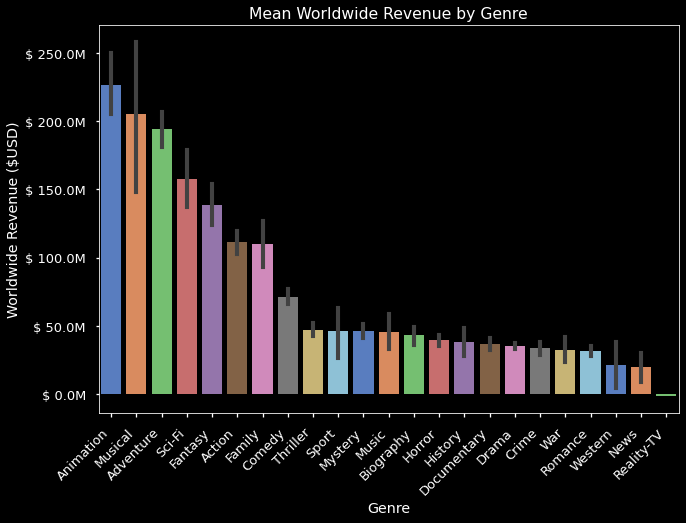

In [51]:
## Plot the average worldwide revenue
ax = sns.barplot(data=genre_df,x='genre_list',y='revenue_worldwide',
            estimator=np.mean, ci=68,order=genre_order,palette=palette_muted)

## Customize plot
formatter = get_funcformatter(kind='M')
ax.yaxis.set_major_formatter(formatter)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right');
ax.set(title='Mean Worldwide Revenue by Genre',
      ylabel='Worldwide Revenue ($USD)',
      xlabel='Genre')

- There are several genres with similar mean revenue. The top 5 most successful genres by mean are:
    - Animation
    - Musical
    - Adventure 
    - Sci-Fi
    - Fantasy

#### Median Revenue 

In [52]:
genre_order = genre_df.groupby('genre_list').median()['revenue_worldwide']\
                                        .sort_values(ascending=False).index

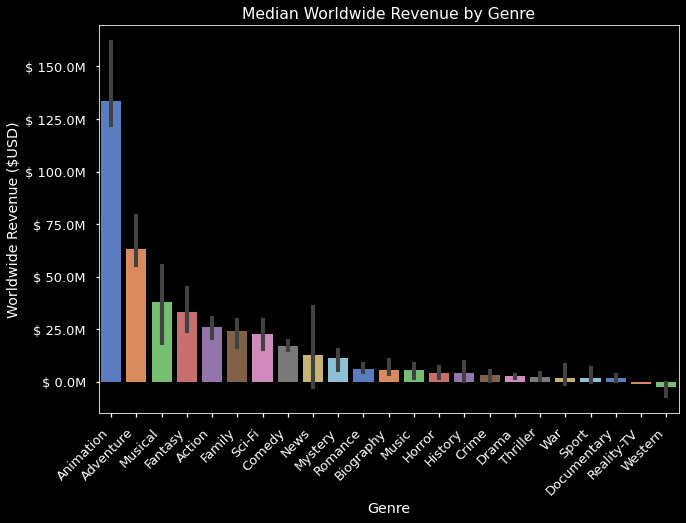

In [53]:
## Plot the average worldwide revenue
ax = sns.barplot(data=genre_df,x='genre_list',y='revenue_worldwide',
            estimator=np.median, ci=68,order=genre_order,palette=palette_muted)

## Customize plot
formatter = get_funcformatter(kind='M')
ax.yaxis.set_major_formatter(formatter)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right');
ax.set(title='Median Worldwide Revenue by Genre',
      ylabel='Worldwide Revenue ($USD)',
      xlabel='Genre');

- When analyzed by median, the results are very clear that Animation is by far the most profitable genre, with Adventure a distant second-place.

### Q1 Conclusion & Recommendation

- We recommend Microsoft produce Animated movies, as they are reliably the most profitable genre world-wide. 

## Q2: Does the release month affect worldwide revenue?

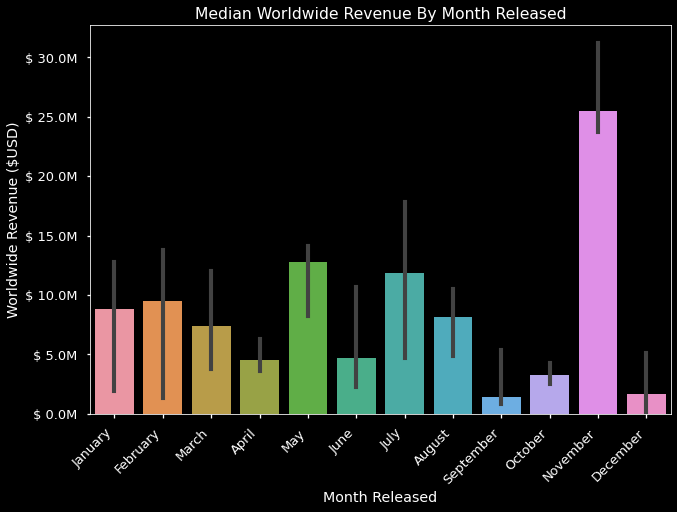

In [54]:
month_names = ['January','February','March','April','May','June',
             'July','August','September','October','November',
             'December']
ax = sns.barplot(data=df, x='release_month',y='revenue_worldwide',
               estimator=np.median,ci=68)#,aspect=1.5)
ax.set_xticklabels(month_names,rotation=45,ha='right');
ax.yaxis.set_major_formatter(formatter)
ax.set(title='Median Worldwide Revenue By Month Released',
      ylabel='Worldwide Revenue ($USD)',xlabel='Month Released');

- By far, movies released in November have higher median revenue than other month.

### Q2 Conclusion & Recommendation

- We recommend Microsoft release their movies in May. 
    - If that isn't possible, aim for May to take advantage of summer-month boost

# Q3: Do movies with higher budget earn more revenue?

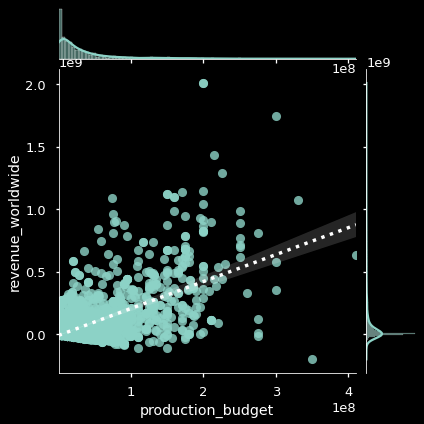

In [55]:
g = sns.jointplot(data=df,x='production_budget',y='revenue_worldwide',
                   kind='reg',line_kws={'color':'white','ls':':'})

# g.x.set_title('Production Budget vs Worldwide Revenue')
# gx.yaxis.set_major_formatter(formatter)
# ax.xaxis.set_major_formatter(formatter)
# ax.set(title='Worldwide Revenue vs Production Budget');

### Q3 Conclusion & Recommendation

- Overall there is a positive correlation between Production Budget and Worldwide Revenue. 
    - However, movies with high budgets that LOSE money.

- We recommend Microsoft be generous with their production budgets, but to realize that a higher budget does not guarantee success.

# Conclusion

- We analyzed over 3,000 films from the last ~10 years and found attributes of successful movies. 

- To recap our recommendations:
    - We recommend that Microsoft make a movie in the Animation genre.
    - We recommended they release their movies in December (or May).
    - We recommend they be generous with their budgets but to not assume higher budget = more revenue. 